In [ ]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
!pip install transformers
import transformers
from transformers import BertTokenizer, ReformerConfig, ReformerPreTrainedModel
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import ReformerPreTrainedModel, ReformerModel, ReformerConfig
from transformers.file_utils import add_start_docstrings_to_model_forward, add_code_sample_docstrings, add_start_docstrings

In [ ]:
import logging
import warnings

import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss, MSELoss, BCEWithLogitsLoss

from transformers.modeling_outputs import  SequenceClassifierOutput
from transformers import ReformerModel ,ReformerPreTrainedModel, ReformerConfig
from transformers.file_utils import add_start_docstrings
_CONFIG_FOR_DOC = "ReformerConfig"
_TOKENIZER_FOR_DOC = "ReformerTokenizer"
_CHECKPOINT_FOR_DOC = "reformer-base-uncased"

REFORMER_INPUTS_DOCSTRING = r"""
    Args:
        input_ids (:obj:`torch.LongTensor` of shape :obj:`(batch_size, sequence_length)`):
            Indices of input sequence tokens in the vocabulary. During training the input_ids sequence_length has to be
            a multiple of the relevant model's chunk lengths (lsh's, local's or both). During evaluation, the indices
            are automatically padded to be a multiple of the chunk length.

            Indices can be obtained using :class:`~transformers.ReformerTokenizer`. See
            :meth:`transformers.PreTrainedTokenizer.encode` and :meth:`transformers.PreTrainedTokenizer.__call__` for
            details.

            `What are input IDs? <../glossary.html#input-ids>`__
        attention_mask (:obj:`torch.FloatTensor` of shape :obj:`(batch_size, sequence_length)`, `optional`):
            Mask to avoid performing attention on padding token indices. Mask values selected in ``[0, 1]``:

            - 1 for tokens that are **not masked**,
            - 0 for tokens that are **masked**.

            `What are attention masks? <../glossary.html#attention-mask>`__
        position_ids (:obj:`torch.LongTensor` of shape :obj:`(batch_size, sequence_length)`, `optional`):
            Indices of positions of each input sequence tokens in the position embeddings. Selected in the range ``[0,
            config.max_position_embeddings - 1]``.

            `What are position IDs? <../glossary.html#position-ids>`__
        head_mask (:obj:`torch.FloatTensor` of shape :obj:`(num_heads,)` or :obj:`(num_layers, num_heads)`, `optional`):
            Mask to nullify selected heads of the self-attention modules. Mask values selected in ``[0, 1]``:

            - 1 indicates the head is **not masked**,
            - 0 indicates the head is **masked**.

        inputs_embeds (:obj:`torch.FloatTensor` of shape :obj:`(batch_size, sequence_length, hidden_size)`, `optional`):
            Optionally, instead of passing :obj:`input_ids` you can choose to directly pass an embedded representation.
            This is useful if you want more control over how to convert :obj:`input_ids` indices into associated
            vectors than the model's internal embedding lookup matrix.
        num_hashes (:obj:`int`, `optional`):
            The number of hashing rounds that should be performed during bucketing. Setting this argument overwrites
            the default defined in :obj:`config.num_hashes`.

            For more information, see :obj:`num_hashes` in :class:`~transformers.ReformerConfig`.
        past_buckets_states (:obj:`List[Tuple(torch.LongTensor, torch.FloatTensor)]`, `optional`):
            List of :obj:`Tuple(torch.LongTensor, torch.FloatTensor` of length :obj:`config.n_layers`, with the first
            element being the previous `buckets` of shape :obj:`(batch_size, num_heads, num_hashes, sequence_length)`)
            and the second being the previous `hidden_states` of shape :obj:`(batch_size, sequence_length,
            hidden_size)`).

            Contains precomputed hidden-states and buckets (only relevant for LSH Self-Attention). Can be used to speed
            up sequential decoding.
        use_cache (:obj:`bool`, `optional`):
            If set to :obj:`True`, :obj:`past_key_values` key value states are returned and can be used to speed up
            decoding (see :obj:`past_key_values`).
        output_attentions (:obj:`bool`, `optional`):
            Whether or not to return the attentions tensors of all attention layers. See ``attentions`` under returned
            tensors for more detail.
        output_hidden_states (:obj:`bool`, `optional`):
            Whether or not to return the hidden states of all layers. See ``hidden_states`` under returned tensors for
            more detail.
        return_dict (:obj:`bool`, `optional`):
            Whether or not to return a :class:`~transformers.file_utils.ModelOutput` instead of a plain tuple.
"""

class ReformerForSequenceClassification(ReformerPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.config = config

        self.reformer = ReformerModel(config)
        classifier_dropout = (
            config.classifier_dropout if config.classifier_dropout is not None else config.hidden_dropout_prob
        )
        self.dropout = nn.Dropout(classifier_dropout)
        self.classifier = nn.Linear(2*config.hidden_size, config.num_labels)

        self.init_weights()
    @add_start_docstrings_to_model_forward(REFORMER_INPUTS_DOCSTRING.format("batch_size, sequence_length"))
    @add_code_sample_docstrings(
        tokenizer_class=_TOKENIZER_FOR_DOC,
        checkpoint=_CHECKPOINT_FOR_DOC,
        output_type=SequenceClassifierOutput,
        config_class=_CONFIG_FOR_DOC,
    )
    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size,)`, `optional`):
            Labels for computing the sequence classification/regression loss. Indices should be in :obj:`[0, ...,
            config.num_labels - 1]`. If :obj:`config.num_labels == 1` a regression loss is computed (Mean-Square loss),
            If :obj:`config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.reformer(
            input_ids,
            attention_mask=attention_mask,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]
        logits = self.classifier(sequence_output)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


In [ ]:
 # Load data and set labels
data = pd.read_csv('/content/newtrainuris.csv')

data.head(5)

,label,text
0,1,List all boardgames by GMT. ; http://dbpedia.o...
1,0,List all boardgames by GMT. ; http://dbpedia.o...
2,0,Who are the developers of Skype? ; http://dbpe...
3,1,Who are the developers of Skype? ; http://dbpe...
4,1,Which people were born in Heraklion? ; http://...


In [ ]:
from sklearn.model_selection import train_test_split

X = data.text.values
y = data.label.values

X_train, X_val, y_train, y_val =\
    train_test_split(X, y, test_size=0.2, random_state=2020)

In [ ]:
# Load test data
test_data = pd.read_csv('testuris.csv')

# Keep important columns
test_data = test_data[['text']]
test_data.sample(5)

,text
1,Which bridges cross the Seine? ; http://dbpedi...
11,How many movies did Park Chan-wook direct? ; ...
6,How many films did Hal Roach produce? ; http:/...
12,How many movies did Park Chan-wook direct? ; h...
9,Give me all companies in Munich. ; http://dbpe...


In [ ]:
import torch

if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla P100-PCIE-16GB


In [ ]:
import nltk
# Uncomment to download "stopwords"
nltk.download("stopwords")
from nltk.corpus import stopwords

def text_preprocessing(s):
    """
    - Lowercase the sentence
    - Change "'t" to "not"
    - Remove "@name"
    - Isolate and remove punctuations except "?"
    - Remove other special characters
    - Remove stop words except "not" and "can"
    - Remove trailing whitespace
    """
    #s = s.lower()
    # Change 't to 'not'
    #s = re.sub(r"\'t", " not", s)
    # Remove @name
    #s = re.sub(r'(@.*?)[\s]', ' ', s)
    # Isolate and remove punctuations except '?'
    #s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    #s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    #s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
   # s = " ".join([word for word in s.split()
    #              if word not in stopwords.words('english')
    #              or word in ['not', 'can']])
    # Remove trailing whitespace
    #s = re.sub(r'\s+', ' ', s).strip()
    
    return s

In [ ]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocess text
X_train_preprocessed = np.array([text_preprocessing(text) for text in X_train])
X_val_preprocessed = np.array([text_preprocessing(text) for text in X_val])

# Calculate TF-IDF
tf_idf = TfidfVectorizer(ngram_range=(1, 3),
                         binary=True,
                         smooth_idf=False)
X_train_tfidf = tf_idf.fit_transform(X_train_preprocessed)
X_val_tfidf = tf_idf.transform(X_val_preprocessed)

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

def get_auc_CV(model):
    """
    Return the average AUC score from cross-validation.
    """
    # Set KFold to shuffle data before the split
    kf = StratifiedKFold(5, shuffle=True, random_state=1)

    # Get AUC scores
    auc = cross_val_score(
        model, X_train_tfidf, y_train, scoring="roc_auc", cv=kf)

    return auc.mean()

Best alpha:  6.7


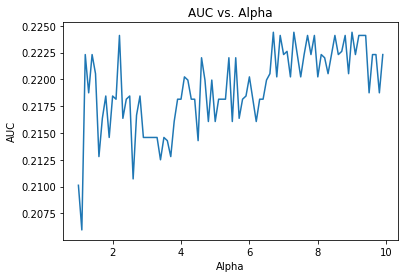

In [ ]:
from sklearn.naive_bayes import MultinomialNB

res = pd.Series([get_auc_CV(MultinomialNB(i))
                 for i in np.arange(1, 10, 0.1)],
                index=np.arange(1, 10, 0.1))

best_alpha = np.round(res.idxmax(), 2)
print('Best alpha: ', best_alpha)

plt.plot(res)
plt.title('AUC vs. Alpha')
plt.xlabel('Alpha')
plt.ylabel('AUC')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, auc

def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

AUC: 0.0000
Accuracy: 16.67%


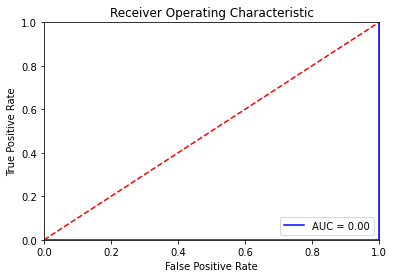

In [ ]:
# Compute predicted probabilities
nb_model = MultinomialNB(alpha=1.8)
nb_model.fit(X_train_tfidf, y_train)
probs = nb_model.predict_proba(X_val_tfidf)

# Evaluate the classifier
evaluate_roc(probs, y_val)

In [ ]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    #text = re.sub(r'(;?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    #text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    #text = re.sub(r'\s+', ' ', text).strip()

    return text

In [ ]:
# Print sentence 0
print('Original: ', X[10])
print('Processed: ', text_preprocessing(X[10]))

Original:  Who is the mayor of New York City? ;  http://dbpedia.org/resource/Airports_in_New_York_City
Processed:  Who is the mayor of New York City? ;  http://dbpedia.org/resource/Airports_in_New_York_City


In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing(data):
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [ ]:
# Concatenate train data and test data
all_text = np.concatenate([data.text.values, test_data.text.values])

# Encode our concatenated data
encoded_text = [tokenizer.encode(sent, add_special_tokens=True) for sent in all_text]

# Find the maximum length
max_len = max([len(sent) for sent in encoded_text])
print('Max length: ', max_len)

Max length:  56


In [ ]:
# Specify `MAX_LEN`
MAX_LEN = 128

# Print sentence 0 and its encoded token ids
token_ids = list(preprocessing([X[0]])[0].squeeze().numpy())
print('Original: ', X[0])
print('Token IDs: ', token_ids)
print('Tokenizing data...')
train_inputs, train_masks = preprocessing(X_train)
val_inputs, val_masks = preprocessing(X_val)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)
batch_size = 32
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [ ]:
config = ReformerConfig(num_labels = 2, vocab_size=30522,axial_pos_shape=[16,8], 
                                     dropout=0.7,
                                     attn_layers=['local', 'lsh', 'local', 'lsh', 'local', 'lsh','local', 'lsh', 'local', 'lsh', 'local', 'lsh'])
#sequencemodel = ReformerForSequenceClassification(config)
#config = sequencemodel.config

In [ ]:
#sequencemodel = ReformerForSequenceClassification(config = config)

In [ ]:
import torch
import torch.nn as nn
from transformers import ReformerModel

class ReformerClassifier(ReformerPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.config = config

        self.reformer = ReformerModel(config)
        classifier_dropout = (
            config.classifier_dropout if config.classifier_dropout is not None else config.hidden_dropout_prob
        )
        self.dropout = nn.Dropout(classifier_dropout)
        #self.classifier = nn.Linear(2*config.hidden_size, config.num_labels)
        self.classifier = nn.Linear(2*config.hidden_size, config.num_labels)
        self.init_weights()
        
    def forward(self, input_ids, attention_mask):
        
        outputs = self.reformer(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :] 

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

def initialize_model(epochs=50):
    print(config)
    reformer_classifier = ReformerClassifier(config)
    reformer_classifier.to(device)
    optimizer = AdamW(reformer_classifier.parameters(),
                      lr=3e-5,
                      eps=1e-12 
                      )
    print(optimizer)
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, 
                                                num_training_steps=total_steps)
    return reformer_classifier, optimizer, scheduler
    

In [ ]:
import random
import time

loss_fn = nn.CrossEntropyLoss()
tl, vl =[],[]
def set_seed(seed_value=42):
    
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=50, evaluation=False):
    
    # Start training loop
    print("Start training...\n")
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        t0_epoch, t0_batch = time.time(), time.time()

        total_loss, batch_loss, batch_counts = 0, 0, 0
        model.zero_grad()
        model.train()
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            model.zero_grad()

            logits = model(b_input_ids, b_attn_mask)
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
            scheduler.step()
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                time_elapsed = time.time() - t0_batch

                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        avg_train_loss = total_loss / len(train_dataloader)
        tl.append(avg_train_loss)
        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            val_loss, val_accuracy = evaluate(model, val_dataloader)

            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")


def evaluate(model, val_dataloader):
  
    model.eval()
    val_accuracy = []
    val_loss = []
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = torch.argmax(logits, dim=1).flatten()

        # Calculate the accuracy rate
        accuracy = (preds == b_labels).cpu().numpy().mean() * 100
        val_accuracy.append(accuracy)

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    vl.append(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy

In [ ]:
set_seed(42)    # Set seed for reproducibility
reformer_classifier, optimizer, scheduler = initialize_model(epochs=100)
train(reformer_classifier, train_dataloader, val_dataloader, epochs=100, evaluation=True)

ReformerConfig {
  "attention_head_size": 64,
  "attn_layers": [
    "local",
    "lsh",
    "local",
    "lsh",
    "local",
    "lsh",
    "local",
    "lsh",
    "local",
    "lsh",
    "local",
    "lsh"
  ],
  "axial_norm_std": 1.0,
  "axial_pos_embds": true,
  "axial_pos_embds_dim": [
    64,
    192
  ],
  "axial_pos_shape": [
    16,
    8
  ],
  "chunk_size_lm_head": 0,
  "classifier_dropout": null,
  "dropout": 0.7,
  "eos_token_id": 2,
  "feed_forward_size": 512,
  "hash_seed": null,
  "hidden_act": "relu",
  "hidden_dropout_prob": 0.05,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-12,
  "local_attention_probs_dropout_prob": 0.05,
  "local_attn_chunk_length": 64,
  "local_num_chunks_after": 0,
  "local_num_chunks_before": 1,
  "lsh_attention_probs_dropout_prob": 0.0,
  "lsh_attn_chunk_length": 64,
  "lsh_num_chunks_after": 0,
  "lsh_num_chunks_before": 1,
  "max_position_embeddings": 4096,
  "model_type": "reformer",
  "num_attention_heads": 12,


/usr/local/lib/python3.7/dist-packages/transformers/models/reformer/modeling_reformer.py:1164: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at  ../aten/src/ATen/native/TensorCompare.cpp:328.)
  query_key_dots = torch.where(mask, query_key_dots, mask_value)
config.num_buckets is not set. Setting config.num_buckets to 4...


AdamW (
Parameter Group 0
    betas: (0.9, 0.999)
    correct_bias: True
    eps: 1e-12
    lr: 3e-05
    weight_decay: 0.0
)
Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------


config.num_buckets is not set. Setting config.num_buckets to 4...
config.num_buckets is not set. Setting config.num_buckets to 4...
config.num_buckets is not set. Setting config.num_buckets to 4...
config.num_buckets is not set. Setting config.num_buckets to 4...
config.num_buckets is not set. Setting config.num_buckets to 4...


   1    |    2    |   0.762973   |     -      |     -     |   0.84   
----------------------------------------------------------------------
   1    |    -    |   0.762973   |  0.707424  |   38.89   |   0.88   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   2    |    2    |   0.784325   |     -      |     -     |   0.59   
----------------------------------------------------------------------
   2    |    -    |   0.784325   |  0.744539  |   38.89   |   0.63   
----------------------------------------------------------------------


 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   3    |    2    |   0.643167   |     -      |     -     |   0.60   
----------------------------------------------------------------------
   3    |

In [ ]:
#tl = [0.700088, 0.654977,0.594225, 0.502079,0.435816,0.351477, 0.309446,0.230306, 0.240411,0.225689 ]

In [ ]:
PATH = "ModelBT100EL.pt"
torch.save(reformer_classifier.state_dict(), PATH)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(tl, 'b-o', label="training loss")
plt.plot(vl, 'r-o', label="validation loss")
#plt.plot(f1_scores, 'y-o', label="f1")
# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

Evaluation on Validation Set


In [ ]:
import torch.nn.functional as F

def reformer_predict(model, test_dataloader):
    """Perform a forward pass on the trained BERT model to predict probabilities
    on the test set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    all_logits = []

    # For each batch in our test set...
    for batch in test_dataloader:
        # Load batch to GPU
        b_input_ids, b_attn_mask = tuple(t.to(device) for t in batch)[:2]

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_ids, b_attn_mask)
        all_logits.append(logits)
    
    # Concatenate logits from each batch
    all_logits = torch.cat(all_logits, dim=0)

    # Apply softmax to calculate probabilities
    probs = F.softmax(all_logits, dim=1).cpu().numpy()

    return probs

AUC: 0.7273
Accuracy: 72.22%


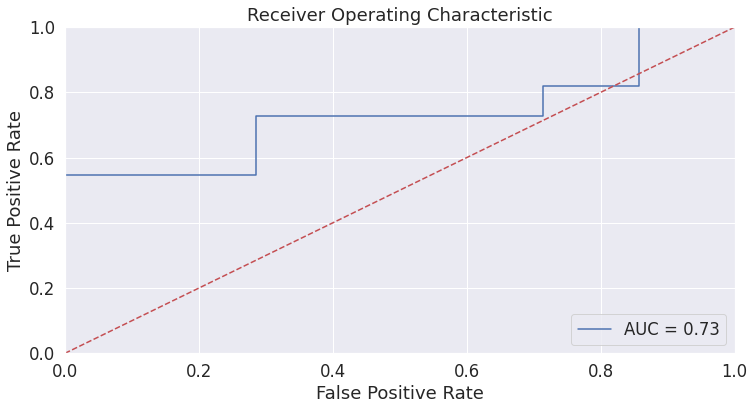

In [ ]:
# Compute predicted probabilities on the test set
probs = reformer_predict(reformer_classifier, val_dataloader)

# Evaluate the Bert classifier
evaluate_roc(probs, y_val)

In [ ]:
# Concatenate the train set and the validation set
full_train_data = torch.utils.data.ConcatDataset([train_data, val_data])
full_train_sampler = RandomSampler(full_train_data)
full_train_dataloader = DataLoader(full_train_data, sampler=full_train_sampler, batch_size=32)

# Train the Bert Classifier on the entire training data
set_seed(42)
reformer_classifier, optimizer, scheduler = initialize_model(epochs=10)
train(reformer_classifier, full_train_dataloader, epochs=10)

Predictions on Test Set


In [ ]:
test_data.sample(5)

,text
9,Give me all companies in Munich. ; http://dbpe...
11,How many movies did Park Chan-wook direct? ; ...
0,Which bridges cross the Seine? ; http://dbpedi...
12,How many movies did Park Chan-wook direct? ; h...
5,How many films did Hal Roach produce? ; http:/...


In [ ]:
# Run `preprocessing_for_bert` on the test set
print('Tokenizing data...')
test_inputs, test_masks = preprocessing(test_data.text)

# Create the DataLoader for our test set
test_dataset = TensorDataset(test_inputs, test_masks)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=32)

In [ ]:
# Compute predicted probabilities on the test set
probs = reformer_predict(reformer_classifier, test_dataloader)

# Get predictions from the probabilities
threshold = 0.5
preds = np.where(probs[:, 1] > threshold, 1, 0)

# Number of tweets predicted non-negative
print("Number of entity labels predicted as 1: ", preds.sum())

Number of entity labels predicted as 1:  5


In [ ]:
output = test_data[preds==1]
list(output.sample(5).text)